<a href="https://colab.research.google.com/github/YelisettyRahul/Lung-Colon-Histopathological-Images-Classification/blob/main/Lung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import time
import itertools

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7 as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

print('Modules loaded')

Modules loaded


In [ ]:
import zipfile

In [ ]:
!unzip "/content/drive/MyDrive/lung_image.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lung _image/lung_scc/lungscc1.jpeg  
  inflating: lung _image/lung_scc/lungscc10.jpeg  
  inflating: lung _image/lung_scc/lungscc100.jpeg  
  inflating: lung _image/lung_scc/lungscc1000.jpeg  
  inflating: lung _image/lung_scc/lungscc1001.jpeg  
  inflating: lung _image/lung_scc/lungscc1002.jpeg  
  inflating: lung _image/lung_scc/lungscc1003.jpeg  
  inflating: lung _image/lung_scc/lungscc1004.jpeg  
  inflating: lung _image/lung_scc/lungscc1005.jpeg  
  inflating: lung _image/lung_scc/lungscc1006.jpeg  
  inflating: lung _image/lung_scc/lungscc1007.jpeg  
  inflating: lung _image/lung_scc/lungscc1008.jpeg  
  inflating: lung _image/lung_scc/lungscc1009.jpeg  
  inflating: lung _image/lung_scc/lungscc101.jpeg  
  inflating: lung _image/lung_scc/lungscc1010.jpeg  
  inflating: lung _image/lung_scc/lungscc1011.jpeg  
  inflating: lung _image/lung_scc/lungscc1012.jpeg  
  inflating: lung _image/lung_scc/lungscc1013.jpeg  
  

In [ ]:
import os
#walk through 10 classes of food image data
for dirpath,dirnames,filenames in os.walk("/content/lung_image"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/lung_image'.
There are 0 directories and 5000 images in '/content/lung_image/lung_scc'.
There are 0 directories and 5000 images in '/content/lung_image/lung_aca'.
There are 0 directories and 5000 images in '/content/lung_image/lung_n'.


In [ ]:
import pathlib
import numpy as np
data_dir=pathlib.Path("/content/lung_image")
class_names=np.array(sorted([item.name for item in data_dir.glob("*")]))
#created a list of class_names fro the subdirectory

In [ ]:
print(class_names)

['lung_aca' 'lung_n' 'lung_scc']


In [ ]:
# Generate data paths with labels
data_dir = '/content/lung_image'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

,filepaths,labels
0,/content/lung_image/lung_scc/lungscc3767.jpeg,lung_scc
1,/content/lung_image/lung_scc/lungscc4153.jpeg,lung_scc
2,/content/lung_image/lung_scc/lungscc2512.jpeg,lung_scc
3,/content/lung_image/lung_scc/lungscc2653.jpeg,lung_scc
4,/content/lung_image/lung_scc/lungscc4744.jpeg,lung_scc
...,...,...
14995,/content/lung_image/lung_n/lungn2606.jpeg,lung_n
14996,/content/lung_image/lung_n/lungn784.jpeg,lung_n
14997,/content/lung_image/lung_n/lungn1491.jpeg,lung_n
14998,/content/lung_image/lung_n/lungn1279.jpeg,lung_n


#train and test and valid split

In [ ]:
train , dummy = train_test_split(df , train_size = 0.8 , shuffle = True , random_state= 42 , stratify= df['labels'])
#Split data into validation and test 10% both
valid , test = train_test_split(dummy , train_size = 0.5 , shuffle = True , random_state= 42 , stratify= dummy['labels'])

In [ ]:
train_gen=ImageDataGenerator(horizontal_flip= True,rescale=1/255.)
test_gen=ImageDataGenerator(rescale=1/255.)

In [ ]:
train_data=train_gen.flow_from_dataframe(
    train, x_col = 'filepaths' ,
    y_col = 'labels' ,
    target_size =(224,224),
    class_mode='categorical',
    batch_size= 16,color_mode = "rgb",
    shuffle = True
    )

valid_data = test_gen.flow_from_dataframe(valid,x_col= 'filepaths',
                                         y_col= 'labels',
                                         target_size=(224,224),
                                         class_mode='categorical',
                                         color_mode="rgb",
                                         shuffle = True,
                                         batch_size= 16,

                                        )
test_data = test_gen.flow_from_dataframe(test,x_col = 'filepaths' ,
                                         y_col = 'labels' ,
                                         target_size = (224,224) ,
                                        class_mode = 'categorical',
                                         color_mode = 'rgb' ,
                                         shuffle= False ,
                                         batch_size = 16)



Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Activation

create a model

In [ ]:
model_10=tf.keras.Sequential([
  Conv2D(filters=64,kernel_size=3,
                           activation='relu',
                           input_shape=(224,224,3),padding = 'same'),
  Conv2D(64,3,activation='relu',padding = 'same'),
  MaxPool2D(),
  Conv2D(128,3,activation='relu',padding = 'same'),
  Conv2D(128,3,activation='relu',padding = 'same'),
  MaxPool2D(),
  Conv2D(256,3,activation='relu',padding = 'same'),
  Conv2D(256,3,activation='relu',padding = 'same'),
  Conv2D(256,3,activation='relu',padding = 'same'),
  MaxPool2D(),
  Conv2D(512,3,activation='relu',padding = 'same'),
  Conv2D(512,3,activation='relu',padding = 'same'),
  MaxPool2D(),
  Flatten(),
  Dense(256,activation='relu'),
  Dense(64,activation='relu'),
  Dense(3,activation='softmax')
])

#compile our cnn
model_10.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

#fit the model
history_10=model_10.fit(train_data,#fitting model_6 on augumented training data
                      epochs=10,
                      steps_per_epoch=len(train_data),
                      validation_data=valid_data,
                      validation_steps=None)

KeyboardInterrupt: ignored

In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint("highest-trained.h5",
                                    save_best_only=True,
                                    monitor='val_loss',
                                    verbose=1)

In [ ]:
model_l=tf.keras.Sequential([
  Conv2D(filters=64,kernel_size=3,
                           activation='relu',
                           input_shape=(224,224,3),padding = 'same'),
  Conv2D(64,3,activation='relu',padding = 'same'),
  MaxPool2D(),
  Conv2D(128,3,activation='relu',padding = 'same'),
  Conv2D(128,3,activation='relu',padding = 'same'),
  Conv2D(128,3,activation='relu',padding = 'same'),
  MaxPool2D(),
  Conv2D(256,3,activation='relu',padding = 'same'),
  Conv2D(256,3,activation='relu',padding = 'same'),
  Conv2D(256,3,activation='relu',padding = 'same'),
  MaxPool2D(),
  Conv2D(512,3,activation='relu',padding = 'same'),
  Conv2D(512,3,activation='relu',padding = 'same'),
  Conv2D(512,3,activation='relu',padding = 'same'),
  MaxPool2D(),
  Flatten(),
  Dense(256,activation= 'relu'),
  Dense(64,activation='relu'),
  Dense(3,activation='softmax')
])

#compile our cnn
model_l.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

#fit the model
history_l=model_l.fit(train_data,#fitting model_6 on augumented training data
                      epochs=25,
                      steps_per_epoch=len(train_data),
                      validation_data=valid_data,
                      validation_steps=None,
                      callbacks=[model_checkpoint])

Epoch 1/25
750/750 [==============================] - ETA: 0s - loss: 0.3814 - accuracy: 0.8356
Epoch 1: val_loss improved from inf to 0.19216, saving model to highest-trained.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 198s 237ms/step - loss: 0.3814 - accuracy: 0.8356 - val_loss: 0.1922 - val_accuracy: 0.9253
Epoch 2/25
750/750 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9206
Epoch 2: val_loss did not improve from 0.19216
750/750 [==============================] - 173s 231ms/step - loss: 0.2038 - accuracy: 0.9206 - val_loss: 0.1925 - val_accuracy: 0.9300
Epoch 3/25
750/750 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9367
Epoch 3: val_loss improved from 0.19216 to 0.14033, saving model to highest-trained.h5
750/750 [==============================] - 178s 238ms/step - loss: 0.1709 - accuracy: 0.9367 - val_loss: 0.1403 - val_accuracy: 0.9420
Epoch 4/25
750/750 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9488
Epoch 4: val_loss did not improve from 0.14033
750/750 [==============================] - 173s 230ms/step - loss: 0.1390 - accuracy: 0.9488 - val_loss: 0.2121 - val_accuracy

In [ ]:
model_l.evaluate(test_data)

94/94 [==============================] - 11s 115ms/step - loss: 0.0726 - accuracy: 0.9860


[0.07257332652807236, 0.9860000014305115]

In [ ]:
def load_model(model_path):
  print(f"loading the saved model from : {model_path}")
  new_model=tf.keras.models.load_model(model_path,
                                       custom_objects={"kerasLayer":hub.KerasLayer})
  return new_model

In [ ]:
import tensorflow_hub as hub

In [ ]:
model_top=load_model("/content/highest-trained.h5")

loading the saved model from : /content/highest-trained.h5


In [ ]:
model_top.evaluate(test_data)

94/94 [==============================] - 8s 76ms/step - loss: 0.0503 - accuracy: 0.9833


[0.05032118409872055, 0.9833333492279053]

In [ ]:
ts_length = len(test)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model_top.evaluate(train_data, steps= test_steps, verbose= 1)
valid_score = model_top.evaluate(valid_data, steps= test_steps, verbose= 1)
test_score = model_top.evaluate(test_data, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


20/20 [==============================] - 2s 76ms/step - loss: 0.0353 - accuracy: 0.9875
Train Loss:  0.00997641496360302
Train Accuracy:  1.0
--------------------
Valid Loss:  0.03484872356057167
Valid Accuracy:  0.9906250238418579
--------------------
Test Loss:  0.035309843719005585
Test Accuracy:  0.987500011920929


In [ ]:
from sklearn.metrics import classification_report

Y_pred = model_top.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_data.classes, y_pred))

94/94 [==============================] - 8s 81ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       500
           1       1.00      1.00      1.00       500
           2       0.98      0.98      0.98       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [ ]:

# Create a confusion matrix
from sklearn.metrics import confusion_matrix

# Make predictions
y_preds = model_top.predict(test_data)



94/94 [==============================] - 9s 97ms/step


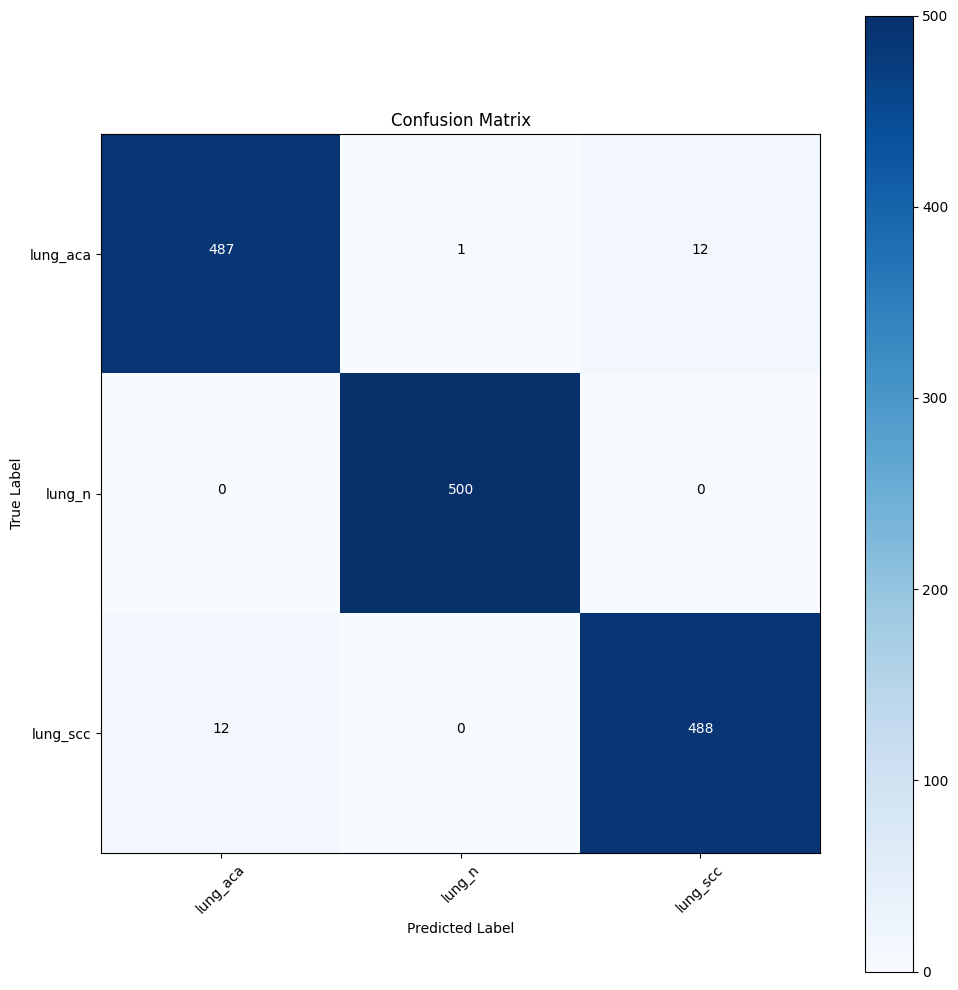

In [ ]:
g_dict = test_data.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_data.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
model_98=load_model("/content/20230918-17581695059896-98%-predict accuracy.h5")

loading the saved model from : /content/20230918-17581695059896-98%-predict accuracy.h5


OSError: ignored